In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn

from tg.projects.punct.context_builder import PunctContextBuilder
from tg.common.ml import batched_training as bt
from tg.common.ml import dft
from tg.common import DataBundle
from tg.grammar_ru.common import Loc
from tg.common.ml.batched_training import context as btc
from tg.common.ml.batched_training import factories as btf

In [2]:
db = DataBundle.load(Loc.bundles_path/'punct/9kk')

In [3]:
idb = bt.IndexedDataBundle(
    index_frame=db.index,
    bundle=db
)

In [4]:
context_builder = PunctContextBuilder(
    include_zero_offset=True,
    left_to_right_contexts_proportion=0.5
)

In [5]:
pymorphy_extractor = (
    bt
    .PlainExtractor
    .build('pymorphy')
    .index()
    .join('pymorphy', on_columns='another_word_id')
    .apply(
        transformer=dft.DataFrameTransformerFactory.default_factory(),
    )
)

In [6]:
def create_assembly_point(context_extractor, context_builder, context_length=20):
    ap = btc.ContextualAssemblyPoint(
        name='features',
        context_builder=context_builder,
        extractor=context_extractor,
        context_length=context_length
    )
    ap.reduction_type = ap.reduction_type.Dim3Folded

    return ap

In [7]:
import pandas as pd
from sklearn.preprocessing import LabelBinarizer


class DataFrameLabelBinarizer():
    def __init__(self, column_name):
        self.column_name = column_name
        self.encoder = LabelBinarizer()

    def fit(self, df):
        self.encoder.fit(df[self.column_name])

        return self

    def transform(self, df):
        transformed_columns = self.encoder.transform(df[self.column_name])
        if transformed_columns.shape[1] == 1:
            result = pd.DataFrame(index=df.index, columns=list(self.encoder.classes_[0]), data=transformed_columns)
        else:
            result = pd.DataFrame(index=df.index, columns=self.encoder.classes_, data=transformed_columns)

        return result

In [8]:
def create_label_extractor():
    label_extractor = (
        bt.PlainExtractor
        .build(btf.Conventions.LabelFrame)
        .index()
        .apply(take_columns='target_word', transformer=DataFrameLabelBinarizer('target_word'))
    )

    return label_extractor

In [9]:
def create_vocab_extractor():
    vocab_extractor = (
        bt.PlainExtractor
        .build('vocab')
        .index()
        .join('sample_to_vocab', on_columns='word_id')
        .apply()
    )

    return vocab_extractor

In [10]:
def create_navec_extractor():
    navec_extractor = (
        bt.PlainExtractor
        .build('navec')
        .index()
        .join('sample_to_navec', on_columns='word_id')
        .apply()
    )

    return navec_extractor

Сеть без embedding слоя

In [11]:
import torch


class PunctNetwork(torch.nn.Module):
    def __init__(self, head, hidden_size, out_size):
        super(PunctNetwork, self).__init__()
        self.head = head
        self.tail = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, out_size),
            torch.nn.Softmax(1)
        )
        
    def forward(self, batch):
        return self.tail(self.head(batch))


class PunctNetworkFactory:
    def __init__(self, assembly_point, out_size):
        self.assembly_point = assembly_point
        self.out_size = out_size
        
    def __call__(self, batch):
        head_factory = self.assembly_point.create_network_factory()
        head = head_factory(batch)

        return PunctNetwork(head, self.assembly_point.hidden_size, self.out_size)

Сеть с embedding слоем

In [12]:
class PunctNetworkEmbedding(torch.nn.Module):
    def __init__(self, embedding_size, features_size, hidden_size, out_size, dropout=0, num_embeddings=10_001):
        super().__init__()
        self.embedding = torch.nn.Embedding(
            num_embeddings,
            embedding_size,
        )
        self.lstm = btc.LSTMNetwork(embedding_size + features_size, hidden_size)
        self.tail = torch.nn.Sequential(
            nn.Dropout(dropout),
            torch.nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.1),
            torch.nn.Linear(hidden_size, out_size),
            torch.nn.Softmax(1)
        )

    def forward(self, batch: bt.IndexedDataBundle):
        features = batch.bundle.features.tensor
        embeddings = self.embedding(torch.tensor(batch.bundle.vocab.vocab_id.values))
        embeddings = embeddings[None,:].repeat(features.shape[0], 1, 1)
        concatenated = torch.cat((features, embeddings), dim=2)

        return self.tail(self.lstm(concatenated))

In [13]:
from navec import Navec
from slovnet.model.emb import NavecEmbedding


class PunctNetworkNavec(nn.Module):
    def __init__(self, embedding_size, features_size, hidden_size, out_size, dropout=0):
        super().__init__()
        self.navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')
        self.NAVEC_EMB_SIZE = 300

        self.embedding = nn.Sequential(
            NavecEmbedding(self.navec),
            nn.Dropout(dropout),
            nn.Linear(self.NAVEC_EMB_SIZE, embedding_size),
            nn.LeakyReLU(0.1)
        )
        self.lstm = btc.LSTMNetwork(embedding_size + features_size, hidden_size)
        self.tail = torch.nn.Sequential(
            nn.Dropout(dropout),
            torch.nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.1),
            torch.nn.Linear(hidden_size, out_size),
            torch.nn.Softmax(1)
        )

    def forward(self, batch: bt.IndexedDataBundle):
        features = batch.bundle.features.tensor
        embeddings = self.embedding(torch.tensor(batch.bundle.navec.navec_id.values))
        embeddings = embeddings[None,:].repeat(features.shape[0], 1, 1)
        concatenated = torch.cat((features, embeddings), dim=2)

        return self.tail(self.lstm(concatenated))

In [14]:
def punct_network_factory_embedding(
        input,
        embedding_size,
        hidden_size,
        out_size,
        dropout=0,
        num_embeddings=10_001
        ):
    features_size = input.bundle.features.tensor.shape[2]

    return PunctNetworkEmbedding(embedding_size, features_size, hidden_size, out_size, dropout, num_embeddings)

In [15]:
def punct_network_factory_navec(
        input,
        embedding_size,
        hidden_size,
        out_size,
        dropout=0
        ):
    features_size = input.bundle.features.tensor.shape[2]

    return PunctNetworkNavec(embedding_size, features_size, hidden_size, out_size, dropout)

* Обучение

In [16]:
class PunctTrainingTask(btf.TorchTrainingTask):
    def __init__(self, features_assembly_point, factory, extractors):
        super(PunctTrainingTask, self).__init__()
        self.metric_pool = bt.MetricPool().add_sklearn(roc_auc_score)
        self.features_assembly_point = features_assembly_point
        self.factory = factory
        self.extractors = extractors
        self.extractors.append(self.features_assembly_point.create_extractor(),)
    
    def initialize_task(self, idb):
        self.setup_batcher(
            idb,
            self.extractors,
            # stratify_by_column='target_word',
            )
        self.setup_model(self.factory, ignore_consistancy_check=True)

In [17]:
from sklearn.metrics import roc_auc_score

from tg.common.ml.batched_training.factories import CtorAdapter


def do_training(network_factory, epoch_count=15):
    punct_features_assembly_point = create_assembly_point(pymorphy_extractor, context_builder)
    punct_features_assembly_point.hidden_size = 50
    punct_features_assembly_point.dim_3_network_factory.network_type = btc.Dim3NetworkType.LSTM

    task = PunctTrainingTask(
        punct_features_assembly_point,
        network_factory,
        [
            create_label_extractor(),
            create_vocab_extractor(),
            create_navec_extractor(),
        ]
    )
    task.settings.batch_size = 5000
    task.settings.mini_batch_size = 1000
    task.settings.mini_epoch_count = 5
    task.settings.epoch_count = epoch_count
    task.loss_ctor = CtorAdapter('torch.nn:CrossEntropyLoss')
    task.optimizer_ctor = CtorAdapter('torch.optim:Adam', ('params',))
    result = task.run(db)

    return result

In [18]:
import functools


# punct_network_factory = PunctNetworkFactory(punct_features_assembly_point, out_size=4)
# punct_factory = functools.partial(
#     punct_network_factory_embedding,
#     num_embeddings=10_001,
#    embedding_size=8,
#    hidden_size=32,
#    out_size=4,
#    dropout=0.2
#)
punct_factory = functools.partial(
    punct_network_factory_navec,
    embedding_size=8,
    hidden_size=32,
    out_size=4,
    dropout=0.4,
) # nice one
punct_factory = functools.partial(
    punct_network_factory_navec,
    embedding_size=32,
    hidden_size=32,
    out_size=4,
    dropout=0.6,
)

In [19]:
results = do_training(punct_factory, 1)

2023-04-14 01:43:50.642727 INFO: Training starts. Info: {}
2023-04-14 01:43:50.645456 INFO: Ensuring/loading bundle. Bundle before:
{'word_to_vocab': {'shape': (10001, 2), 'index_name': 'word'}, 'sample_to_navec': {'shape': (9023195, 2), 'index_name': 'word_id'}, 'index': {'shape': (155617, 7), 'index_name': 'sample_id'}, 'sample_to_vocab': {'shape': (9023195, 2), 'index_name': 'word_id'}, 'src': {'shape': (9023195, 17), 'index_name': None}, 'pymorphy': {'shape': (9023195, 16), 'index_name': 'word_id'}}
2023-04-14 01:43:50.647389 INFO: Bundle loaded
{'word_to_vocab': {'shape': (10001, 2), 'index_name': 'word', 'columns': ['count', 'vocab_id'], 'index': ['UNK', ',', '.', 'в', 'и', '...']}, 'sample_to_navec': {'shape': (9023195, 2), 'index_name': 'word_id', 'columns': ['word', 'navec_id'], 'index': [0, 1, 2, 3, 4, '...']}, 'index': {'shape': (155617, 7), 'index_name': 'sample_id', 'columns': ['word_id', 'sentence_id', 'label', 'reference', 'word_type', '...'], 'index': [122, 274, 336, 57

/home/alabai/studies/grammar_ru/grammar_ru/.venv/lib/python3.8/site-packages/slovnet/model/emb.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  torch.from_numpy(navec.pq.indexes),


2023-04-14 01:44:36.621403 INFO: Initialization completed
2023-04-14 01:44:36.982314 INFO: Epoch 0 of 1
2023-04-14 01:44:46.951694 INFO: Training: 0/22 batch, 0/5 mini-epoch
2023-04-14 01:44:47.621336 INFO: Training: 0/22 batch, 1/5 mini-epoch
2023-04-14 01:44:48.128697 INFO: Training: 0/22 batch, 2/5 mini-epoch
2023-04-14 01:44:48.606036 INFO: Training: 0/22 batch, 3/5 mini-epoch
2023-04-14 01:44:49.134577 INFO: Training: 0/22 batch, 4/5 mini-epoch
2023-04-14 01:45:00.880963 INFO: Training: 1/22 batch, 0/5 mini-epoch
2023-04-14 01:45:01.457023 INFO: Training: 1/22 batch, 1/5 mini-epoch
2023-04-14 01:45:01.971705 INFO: Training: 1/22 batch, 2/5 mini-epoch
2023-04-14 01:45:02.490310 INFO: Training: 1/22 batch, 3/5 mini-epoch
2023-04-14 01:45:03.002123 INFO: Training: 1/22 batch, 4/5 mini-epoch
2023-04-14 01:45:14.744293 INFO: Training: 2/22 batch, 0/5 mini-epoch
2023-04-14 01:45:15.293876 INFO: Training: 2/22 batch, 1/5 mini-epoch
2023-04-14 01:45:15.764868 INFO: Training: 2/22 batch, 2

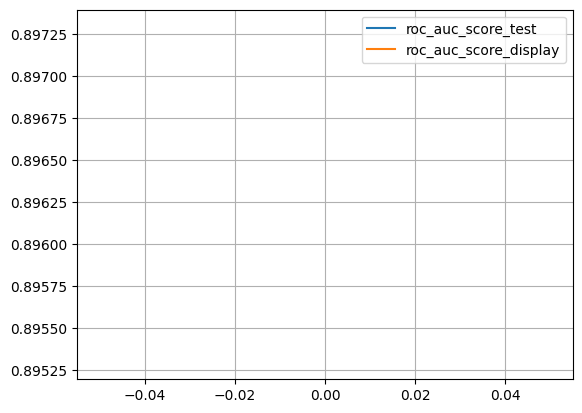

In [20]:
pd.DataFrame(results['output']['history'])[['roc_auc_score_test', 'roc_auc_score_display']].plot()
plt.grid()

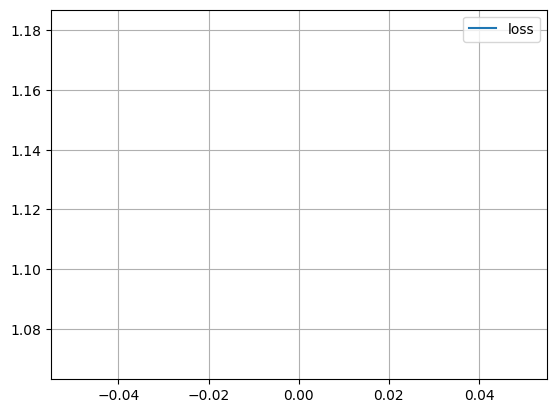

In [21]:
pd.DataFrame(results['output']['history'])[['loss']].plot()
plt.grid()

In [22]:
output_df = results['output']['result_df']
test_predictions = output_df[output_df['stage'] == 'test']

true_columns = test_predictions.columns[test_predictions.columns.str.startswith('true')]
predicted_columns = test_predictions.columns[test_predictions.columns.str.startswith('predicted')]

true_classes = test_predictions[true_columns].values
predictions = test_predictions[predicted_columns].values

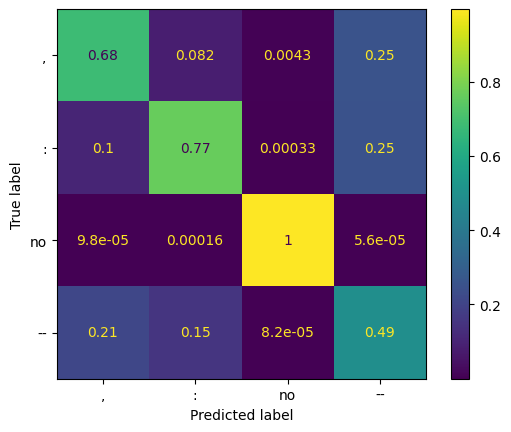

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(np.argmax(true_classes, axis=1), np.argmax(predictions, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm / cm.sum(axis=0), display_labels=[',', ':', 'no', '--'])
disp.plot()

# Experiments

In [34]:
import itertools
import functools

In [35]:
from tg.common._common import Logger


Logger.disable()

In [62]:
from tqdm.notebook import tqdm


embedding_sizes = [0, 1, 2, 4, 8, 16, 23, 64, 128]
dropouts = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
factories = [
    punct_network_factory_embedding,
    punct_network_factory_navec,
]
results = {}

for embedding_size, dropout, factory in tqdm(list(itertools.product(embedding_sizes, dropouts, factories))):
    factory = functools.partial(
        factory,
        hidden_size=32,
        out_size=4,
        embedding_size=embedding_size,
        dropout=dropout,
    )
    results = do_training(factory)
    break

A Jupyter Widget

# Debug

In [95]:
def sentence_from_frame(df):
    return (  # grouping all setnences
        df
        .assign(word_print=(
            df.word + pd.Series(' ', index=df.index) * df.word_tail
        ))
        .groupby('sentence_id').word_print
        .sum()
    )

In [94]:
test_predictions[(test_predictions['true_,'] == 1) & (test_predictions['predicted_—'] > test_predictions['predicted_,'])]

,word_id,sentence_id,label,reference,word_type,target_word,split,priority,"true_,","predicted_,",true_:,predicted_:,true_no,predicted_no,true_—,predicted_—,stage
sample_id,,,,,,,,,,,,,,,,,
3037,3037,2919,0,lenta.base.zip/2919,ru,",",test,0.000493,1,0.014364,0,0.058744,0,0.000034,0,0.926859,test
26908,26908,26751,0,lenta.base.zip/26751,ru,",",test,0.000493,1,0.206364,0,0.278101,0,0.000601,0,0.514934,test
26938,26938,26753,0,lenta.base.zip/26753,ru,",",test,0.000493,1,0.089702,0,0.028578,0,0.000398,0,0.881322,test
41020,41020,40930,0,lenta.base.zip/40930,ru,",",test,0.000493,1,0.021865,0,0.349612,0,0.000050,0,0.628473,test
52233,52233,51964,0,lenta.base.zip/51964,ru,",",test,0.000493,1,0.235090,0,0.004979,0,0.001023,0,0.758907,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621136,621136,621074,0,pub.base.zip/621074,ru,",",test,0.000493,1,0.046630,0,0.105623,0,0.000378,0,0.847369,test
624812,624812,624810,0,pub.base.zip/624810,ru,",",test,0.000493,1,0.433408,0,0.014342,0,0.000061,0,0.552188,test
634006,634006,633984,0,pub.base.zip/633984,ru,",",test,0.000493,1,0.075418,0,0.525500,0,0.000091,0,0.398990,test


In [102]:
idb.bundle.src[(idb.bundle.src['sentence_id'] == 2919) & (idb.bundle.src['word_id'] == 3037)]

,word_id,sentence_id,word_index,paragraph_id,word_tail,word,word_type,word_length,file_id,corpus_id,is_target,label,original_corpus,original_word_id,original_sentence_id,original_paragraph_id,updated
3037,3037,2919,28,2919,0,Ройтфельд,ru,9,67e5392a-ecb6-4172-944e-70753e31894b,transfuzed.zip,True,0,lenta.base.zip,2743756,2650267,2645481,False


In [100]:
sentence_from_frame(idb.bundle.src[idb.bundle.src['sentence_id'] == 2919]).iloc[0]

'Церемония The Fashion Award 2016 прошла 5 декабря в королевском Альберт-холле в британской столице, собрав более четырех тысяч гостей, среди которых были Анна Винтур, Карин Ройтфельд, Дэвид Бекхэм, Карли Клосс, Кейт Мосс, Леди Гага, Лара Стоун, Мэрилин Мэнсон, Марио Тестино, Надя Сваровски, Наоми Кэмпбелл, Сальма Хайек Пино, Том Форд.'